In [14]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# 1. Загрузка данных
df = pd.read_csv('BankChurners.csv')

In [4]:
# 2. Создание целевого признака: 0 если Total_Relationship_Count >=4, иначе 1
df['target'] = np.where(df['Total_Relationship_Count'] >= 4, 0, 1)

In [5]:
# 1. Отделяем целевой признак
y = df['target']
X = df.drop(['target', 'Total_Relationship_Count', 'CLIENTNUM'], axis=1)  # CLIENTNUM - ID, убрать

# 2. Дополнительные признаки
X['Transaction_to_Limit_Ratio'] = df['Total_Trans_Amt'] / df['Credit_Limit']
X['Avg_Transaction_Value'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']

# 3. Удаление сильно коррелированных признаков
corr_matrix = X.select_dtypes(include=[np.number]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X.drop(to_drop, axis=1, inplace=True)

# 4. Вывод удалённых признаков
print("Удаленные признаки с корреляцией > 0.9:")
print(to_drop)

# 5. Вывод итоговой структуры X (в стиле info())
print("\nСтруктура итогового X после удаления признаков:\n")
X.info()


Удаленные признаки с корреляцией > 0.9:
['Avg_Open_To_Buy', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Avg_Transaction_Value']

Структура итогового X после удаления признаков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   Attrition_Flag                                                                                                                      10127 non-null  object 
 1   Customer_Age                                                                                                                        10

In [6]:
# 4. Определяем числовые и категориальные признаки
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [7]:
 # 5. Определяем признаки и создаём препроцессор
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Убираем колонки, которых нет в X — на всякий случай
numeric_features = [col for col in numeric_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Разделяем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Numeric features: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Transaction_to_Limit_Ratio']
Categorical features: ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [8]:
# 6. Предобработка обучающих данных и балансировка SMOTE
X_train_prep = preprocessor.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_prep, y_train)


In [9]:
# 7. Применяем препроцессор к тренировочным данным, затем SMOTE для балансировки
X_train_prep = preprocessor.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_prep, y_train)

In [10]:
# 8. SVM классификатор с ускоренным GridSearch
svm_pipe = Pipeline([
    ('svm', SVC(class_weight='balanced', random_state=42))
])

# Уменьшенное количество параметров для ускорения
svm_params = {
    'svm__C': [1, 10],                 # Два значения
    'svm__kernel': ['linear', 'rbf'], # Два типа ядра
    'svm__gamma': ['scale']           # Один вариант (по умолчанию)
}

# GridSearch с меньшим числом комбинаций и cv=3
svm_grid = GridSearchCV(
    svm_pipe,
    svm_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

# Обучение
svm_grid.fit(X_train_bal, y_train_bal)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('svm',
                                        SVC(class_weight='balanced',
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 10], 'svm__gamma': ['scale'],
                         'svm__kernel': ['linear', 'rbf']},
             scoring='f1')

In [11]:
# 9. Random Forest с GridSearch, сначала с крупным шагом по n_estimators
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Первый этап подбора параметров RF
rf_params_step1 = {
    'rf__n_estimators': [50, 100, 150, 200, 250],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}
rf_grid_step1 = GridSearchCV(rf_pipe, rf_params_step1, cv=5, scoring='f1', n_jobs=-1)
rf_grid_step1.fit(X_train_bal, y_train_bal)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20, 30],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [50, 100, 150, 200, 250]},
             scoring='f1')

<ipython-input-17-13e47ba7c956>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
<ipython-input-17-13e47ba7c956>:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


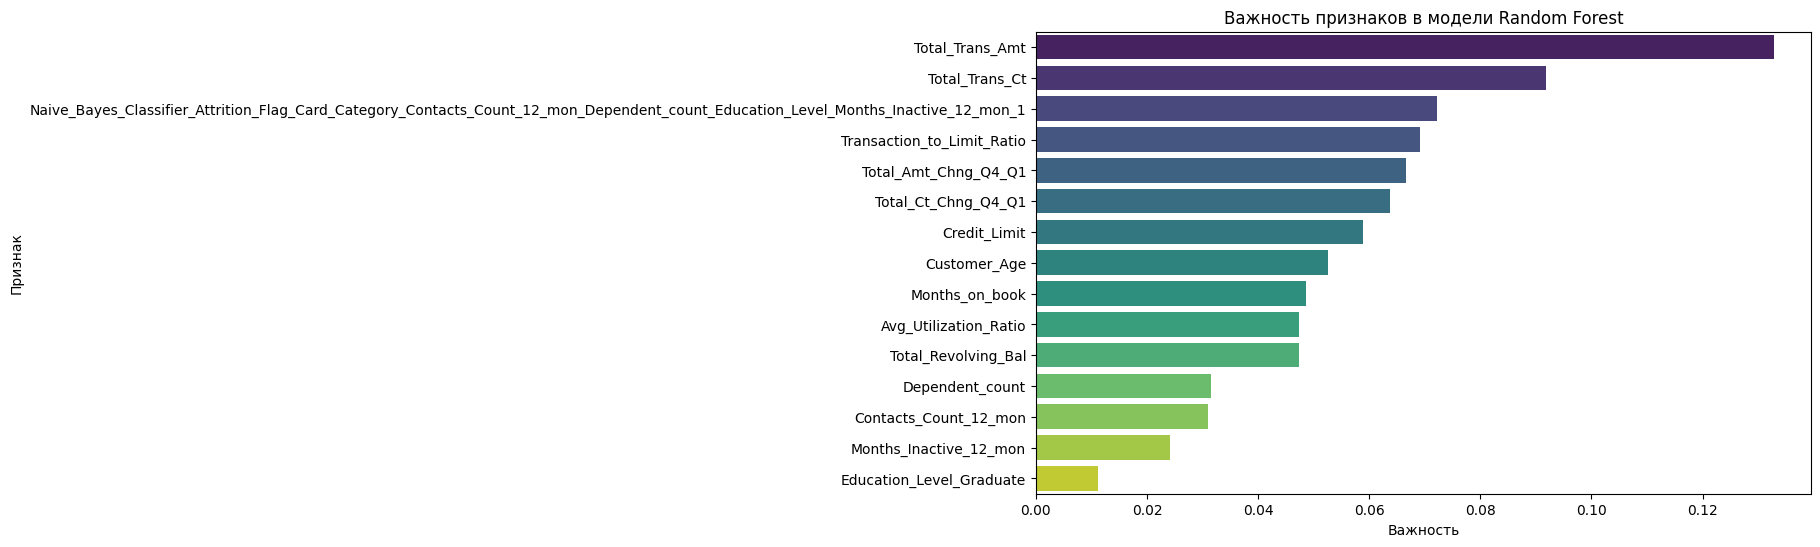

In [17]:
# Второй этап с уточнением числа деревьев
best_n = rf_grid_step1.best_params_['rf__n_estimators']
best_max_depth = rf_grid_step1.best_params_['rf__max_depth']
best_min_split = rf_grid_step1.best_params_['rf__min_samples_split']
best_min_leaf = rf_grid_step1.best_params_['rf__min_samples_leaf']

n_range = list(range(max(10, best_n - 20), best_n + 21, 10))

rf_params_step2 = {
    'rf__n_estimators': n_range,
    'rf__max_depth': [best_max_depth],
    'rf__min_samples_split': [best_min_split],
    'rf__min_samples_leaf': [best_min_leaf]
}
rf_grid_step2 = GridSearchCV(rf_pipe, rf_params_step2, cv=5, scoring='f1', n_jobs=-1)
rf_grid_step2.fit(X_train_bal, y_train_bal)


<ipython-input-19-521ad4f80271>:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


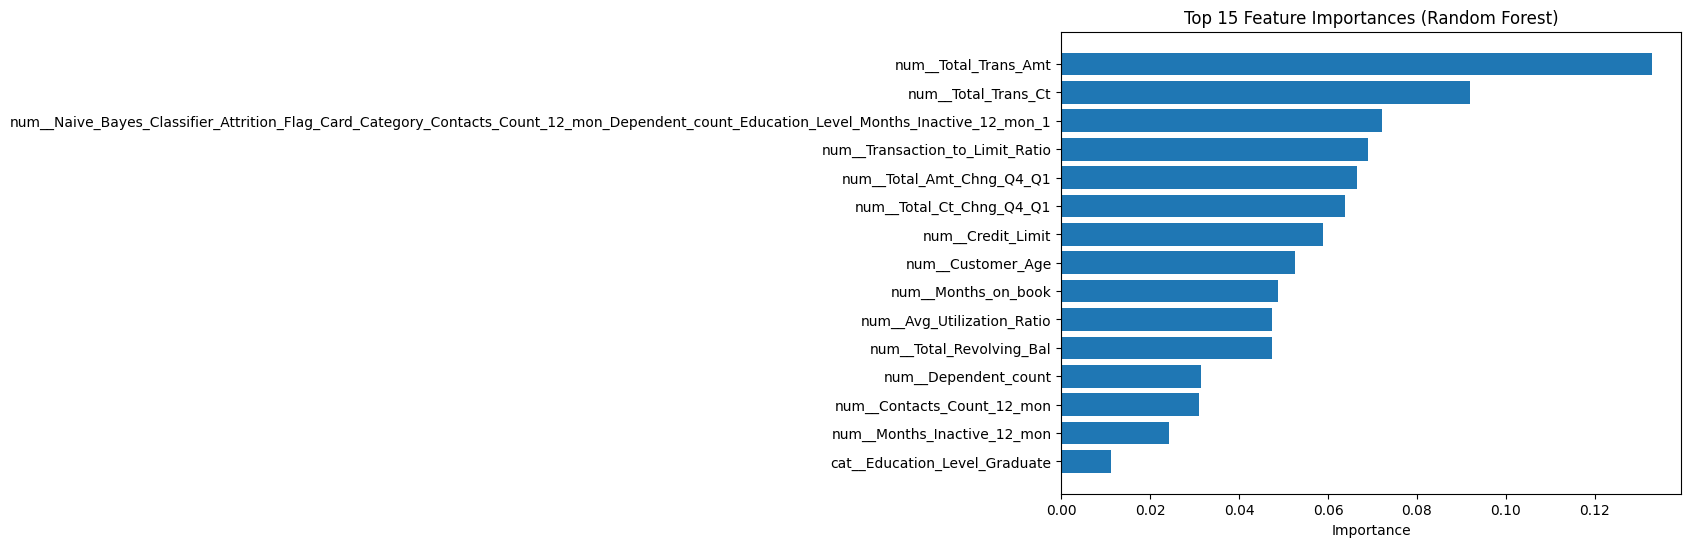

In [19]:
# ==== 11. Feature Importances ====
# Получаем имена признаков после OneHot + Scaling
feature_names = preprocessor.get_feature_names_out()
importances = rf_grid_step2.best_estimator_.named_steps['rf'].feature_importances_

# Сортировка по важности
sorted_idx = np.argsort(importances)[-15:]  # топ-15 признаков
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

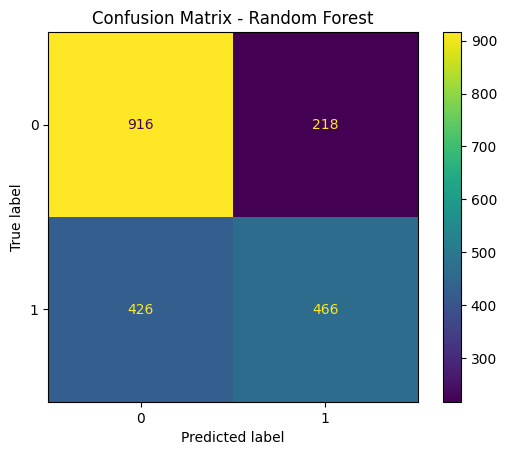

In [20]:
# ==== 12. Confusion Matrix на тестовой выборке ====

# Предсказания на тесте
X_test_prep = preprocessor.transform(X_test)
y_pred_rf = rf_grid_step2.predict(X_test_prep)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [21]:
# 11. Функция для оценки и вывода метрик
def evaluate_model(model, X_test, y_test, preprocessor, model_name):
    X_test_prep = preprocessor.transform(X_test)
    y_pred = model.predict(X_test_prep)
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    return {
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

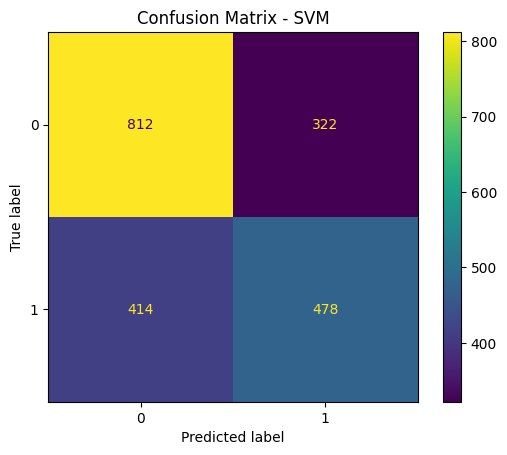

In [23]:
# 12. Confusion Matrix на тестовой выборке: SVM

y_pred_svm = svm_grid.predict(X_test_prep)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title("Confusion Matrix - SVM")
plt.show()


In [24]:
# 13. Оценка моделей
svm_metrics = evaluate_model(svm_grid.best_estimator_, X_test, y_test, preprocessor, "SVM")
rf_metrics = evaluate_model(rf_grid_step2.best_estimator_, X_test, y_test, preprocessor, "Random Forest (Improved)")

print("\nЛучший классификатор по F1:",
      "SVM" if svm_metrics['f1'] > rf_metrics['f1'] else "Random Forest")


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      1134
           1       0.60      0.54      0.57       892

    accuracy                           0.64      2026
   macro avg       0.63      0.63      0.63      2026
weighted avg       0.63      0.64      0.63      2026


Random Forest (Improved) Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1134
           1       0.68      0.52      0.59       892

    accuracy                           0.68      2026
   macro avg       0.68      0.67      0.67      2026
weighted avg       0.68      0.68      0.67      2026


Лучший классификатор по F1: Random Forest
